# Searching a pairwise distance matrix for specific points:

In this notebook you can compare the performance of a classic combinatorics method to find the indices of two points in an array with a precise distance to scipy's squareform method and a [triangular numbers approach](https://mathworld.wolfram.com/TriangularNumber.html).

The first half of this notebook steps through an example of how the triangular numbers approach works. In the second half, you can compare the time required for each method, which clearly displays the decrease in computational time 
of using triangular numbers.

## Roberts playground

In this modified notebook we compare the method with a _brute force_ parallel approach using GPU-accelerated processing, [OpenCL](https://www.khronos.org/opencl/) and the [clesperanto](https://github.com/clEsperanto/pyclesperanto_prototype) library.

In [1]:
# import required functionalities

from __future__ import division, print_function

import time
import numpy as np
import matplotlib.pyplot as plt

from os import getcwd
from os.path import join
from itertools import combinations
from scipy.spatial.distance import pdist, squareform

%matplotlib inline

from functools import partial
from timeit import timeit
import stackview
import pyclesperanto_prototype as cle
from scipy import ndimage as ndi

In [2]:
# define triangular numbers-based search function

def index_pair_from_condensed_form(array, condensed_idx):
    
    '''this function uses triangular numbers formulas to convert a condensed form distance matrix index
       (condensed_idx) into a pair of indices for returning points from the original pointset (array).
       
       
       Let T(x) be the x'th triangular number (i.e., the sum of the numbers from 1 to x). 
       The formula for T(x) is simple:
       T(x) = (x * (x + 1)) / 2
       
       
       Given y = T(x) we can calculate x by inverting the above formula:
       x = (((8y + 1) ** 0.5) - 1) / 2'''
    
    i = condensed_idx
    n = array.shape[0] - 1
    t_n = (n * (n+1)) / 2
    y = t_n - i - 1
    d = 1 + int((((8 * y + 1) ** 0.5) - 1) / 2)
    k = n - d
    k_star = 1 + i + k + ((d * (d + 1)) / 2) - t_n
    
    return int(k), int(k_star)

### Create a matrix with shape (n_pts, 3) to store n points of interest with dimension m (e.g., a pointcloud)

In [3]:
n_pts = 10
m_dim = 3
largest_val = 500

arr = np.random.randint(0, largest_val, (n_pts, m_dim))

### Compute the pairwise distance matrix of the point set

In [4]:
d = pdist(arr)
d

array([474.98842091, 394.48193875, 523.97900721, 334.62068077,
       400.83163548, 538.38740698, 523.97805298, 373.4514694 ,
       360.81851394, 177.12707303, 170.73371079, 350.75490018,
       132.64237634, 193.96133635,  98.87871358, 245.23050381,
       326.46592471, 179.87217684, 206.92752354, 230.93289068,
       284.13553104, 231.38063878,  77.1621669 , 150.61872394,
       285.18239777, 233.24665057, 343.04664406, 249.45340246,
       206.12617495, 302.77054018, 338.88788707, 484.39033847,
       427.37571293, 135.29597185, 161.2482558 , 281.61853632,
       207.31377185, 276.23902693, 359.46905291, 103.00485425,
       360.1291435 , 399.84622044, 307.6800286 , 370.4335298 ,
       102.30347013])

## The distance matrix in square form looks like this

StackViewNDArray([[  0.        , 474.98842091, 394.48193875,
                   523.97900721, 334.62068077, 400.83163548,
                   538.38740698, 523.97805298, 373.4514694 ,
                   360.81851394],
                  [474.98842091,   0.        , 177.12707303,
                   170.73371079, 350.75490018, 132.64237634,
                   193.96133635,  98.87871358, 245.23050381,
                   326.46592471],
                  [394.48193875, 177.12707303,   0.        ,
                   179.87217684, 206.92752354, 230.93289068,
                   284.13553104, 231.38063878,  77.1621669 ,
                   150.61872394],
                  [523.97900721, 170.73371079, 179.87217684,
                     0.        , 285.18239777, 233.24665057,
                   343.04664406, 249.45340246, 206.12617495,
                   302.77054018],
                  [334.62068077, 350.75490018, 206.92752354,
                   285.18239777,   0.        , 338.88788707,
                   484.39033847, 427.37571293, 135.29597185,
                   161.2482558 ],
                  [400.83163548, 132.64237634, 230.93289068,
                   233.24665057, 338.88788707,   0.        ,
                   281.61853632, 207.31377185, 276.23902693,
                   359.46905291],
                  [538.38740698, 193.96133635, 284.13553104,
                   343.04664406, 484.39033847, 281.61853632,
                     0.        , 103.00485425, 360.1291435 ,
                   399.84622044],
                  [523.97805298,  98.87871358, 231.38063878,
                   249.45340246, 427.37571293, 207.31377185,
                   103.00485425,   0.        , 307.6800286 ,
                   370.4335298 ],
                  [373.4514694 , 245.23050381,  77.1621669 ,
                   206.12617495, 135.29597185, 276.23902693,
                   360.1291435 , 307.6800286 ,   0.        ,
                   102.30347013],
                  [360.81851394, 326.46592471, 150.61872394,
                   302.77054018, 161.2482558 , 359.46905291,
                   399.84622044, 370.4335298 , 102.30347013,
                     0.        ]])
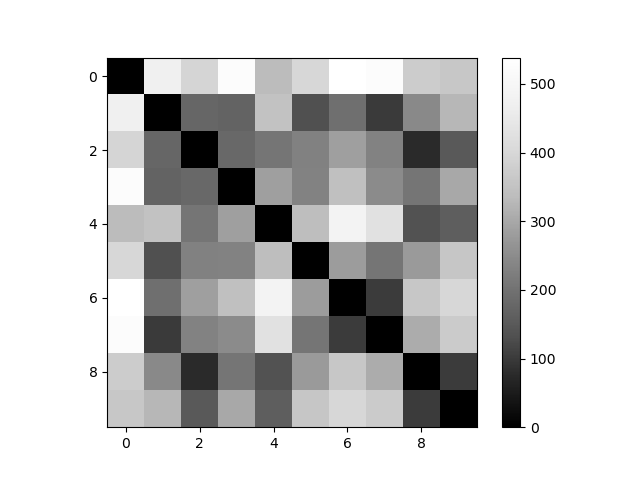
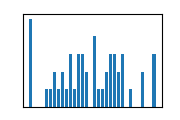

In [5]:
distance_matrix = squareform(d)
stackview.insight(distance_matrix)

## Before we can determine the minimum in this matrix, we should overwrite the diagonale with large values. Therefore it is handy to know the maximum value.

StackViewNDArray([[501.        , 474.98842091, 394.48193875,
                   523.97900721, 334.62068077, 400.83163548,
                   538.38740698, 523.97805298, 373.4514694 ,
                   360.81851394],
                  [474.98842091, 501.        , 177.12707303,
                   170.73371079, 350.75490018, 132.64237634,
                   193.96133635,  98.87871358, 245.23050381,
                   326.46592471],
                  [394.48193875, 177.12707303, 501.        ,
                   179.87217684, 206.92752354, 230.93289068,
                   284.13553104, 231.38063878,  77.1621669 ,
                   150.61872394],
                  [523.97900721, 170.73371079, 179.87217684,
                   501.        , 285.18239777, 233.24665057,
                   343.04664406, 249.45340246, 206.12617495,
                   302.77054018],
                  [334.62068077, 350.75490018, 206.92752354,
                   285.18239777, 501.        , 338.88788707,
                   484.39033847, 427.37571293, 135.29597185,
                   161.2482558 ],
                  [400.83163548, 132.64237634, 230.93289068,
                   233.24665057, 338.88788707, 501.        ,
                   281.61853632, 207.31377185, 276.23902693,
                   359.46905291],
                  [538.38740698, 193.96133635, 284.13553104,
                   343.04664406, 484.39033847, 281.61853632,
                   501.        , 103.00485425, 360.1291435 ,
                   399.84622044],
                  [523.97805298,  98.87871358, 231.38063878,
                   249.45340246, 427.37571293, 207.31377185,
                   103.00485425, 501.        , 307.6800286 ,
                   370.4335298 ],
                  [373.4514694 , 245.23050381,  77.1621669 ,
                   206.12617495, 135.29597185, 276.23902693,
                   360.1291435 , 307.6800286 , 501.        ,
                   102.30347013],
                  [360.81851394, 326.46592471, 150.61872394,
                   302.77054018, 161.2482558 , 359.46905291,
                   399.84622044, 370.4335298 , 102.30347013,
                   501.        ]])
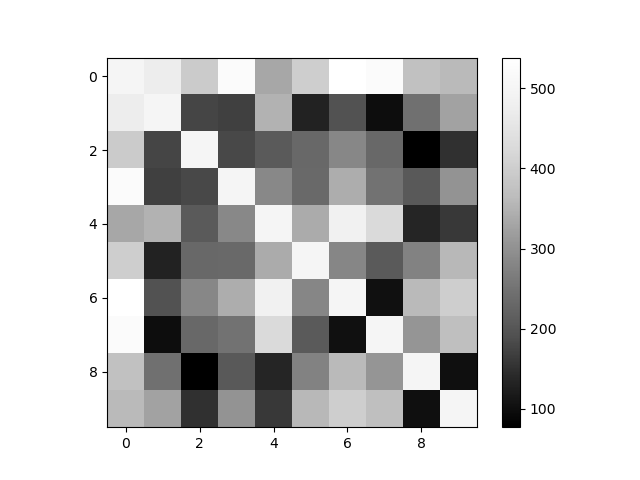
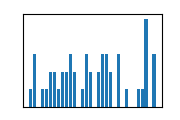

In [6]:
np.fill_diagonal(distance_matrix, largest_val + 1)
stackview.insight(distance_matrix)

In [7]:
ndi.minimum_position(distance_matrix)

(2, 8)

## Formulate the entire thing as function for later benchmarking


In [8]:
def find_minimum_distance_ndi(coords):
    '''
    Finds the point-pair indices with minimal distance in a list of n-dimensional coordinates.
    '''
    d = pdist(arr)
    
    distance_matrix = squareform(d)

    np.fill_diagonal(distance_matrix, largest_val + 1)

    return ndi.minimum_position(distance_matrix)

In [9]:
find_minimum_distance_ndi(arr)

(2, 8)

### Find array index of desired mathematical argument (e.g., minimal distance)

In [10]:
idx = np.argmin(d)
idx

22

### Assign result of mathematical argument to a variable

In [11]:
value = d[idx]
print(value == np.amin(d))

True


### Convert index to pair of indices in original point set

In [12]:
idx_1, idx_2 = index_pair_from_condensed_form(arr, idx)
idx_1, idx_2

(2, 8)

## Formulate the entire thing as function for later benchmarking

In [13]:
def find_minimum_distance_tri(coords):
    '''
    Finds the point-pair indices with minimal distance in a list of n-dimensional coordinates.
    '''
    d = pdist(coords)
    
    idx = np.argmin(d)
    d = pdist(arr)
    idx_1, idx_2 = index_pair_from_condensed_form(arr, idx)

    return (idx_1, idx_2)

In [14]:
find_minimum_distance_tri(arr)

(2, 8)

# GPU 'deceleration'

[`clesperanto`](https://github.com/clEsperanto/pyclesperanto_prototype) expects the points in a different shape. That's why we transpose `.T` it here.

In [15]:
coords = cle.asarray(arr.T)

## Compute distance matrix
In clesperanto distance/adjacency matrices contain a column/row for background. 
To crop it off, we use [1:, 1:]. Then, the matrix is identical with `squareform` above.

cl.OCLArray([[  0.      , 474.9884  , 394.48193 , 523.979   , 334.62067 ,
        400.83163 , 538.3874  , 523.978   , 373.45148 , 360.8185  ],
       [474.9884  ,   0.      , 177.12708 , 170.7337  , 350.75488 ,
        132.64236 , 193.96133 ,  98.878716, 245.2305  , 326.4659  ],
       [394.48193 , 177.12708 ,   0.      , 179.87218 , 206.92752 ,
        230.93289 , 284.13553 , 231.38063 ,  77.16216 , 150.61873 ],
       [523.979   , 170.7337  , 179.87218 ,   0.      , 285.1824  ,
        233.24664 , 343.04663 , 249.4534  , 206.12617 , 302.77054 ],
       [334.62067 , 350.75488 , 206.92752 , 285.1824  ,   0.      ,
        338.88788 , 484.39035 , 427.3757  , 135.29597 , 161.24826 ],
       [400.83163 , 132.64236 , 230.93289 , 233.24664 , 338.88788 ,
          0.      , 281.61853 , 207.31377 , 276.239   , 359.46906 ],
       [538.3874  , 193.96133 , 284.13553 , 343.04663 , 484.39035 ,
        281.61853 ,   0.      , 103.00485 , 360.12915 , 399.84622 ],
       [523.978   ,  98.878716, 231.38063 , 249.4534  , 427.3757  ,
        207.31377 , 103.00485 ,   0.      , 307.68002 , 370.43353 ],
       [373.45148 , 245.2305  ,  77.16216 , 206.12617 , 135.29597 ,
        276.239   , 360.12915 , 307.68002 ,   0.      , 102.30347 ],
       [360.8185  , 326.4659  , 150.61873 , 302.77054 , 161.24826 ,
        359.46906 , 399.84622 , 370.43353 , 102.30347 ,   0.      ]],
      dtype=float32)
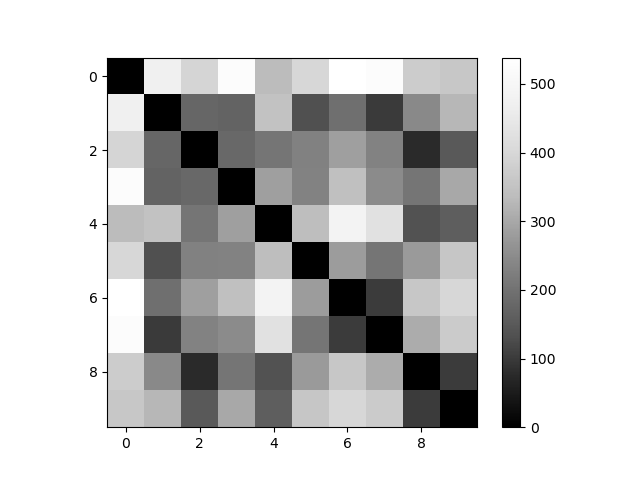
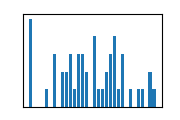

In [16]:
distance_matrix = cle.generate_distance_matrix(coords, coords)[1:,1:]
distance_matrix

In [17]:
# workaround: before determining the minimum position, we should set the diagonale to a high value
# that's a bit wasteful performance-wise but serves the needs
# Note: this will only work if `largest_val` is known. We have to determine it otherwise.
cle.set_where_x_equals_y(distance_matrix, largest_val + 1)

cle.maximum_position(-distance_matrix)

(2, 8)

In [18]:
def find_minimum_distance_cle(coords):
    '''
    Finds the point-pair indices with minimal distance in a list of n-dimensional coordinates.
    '''
    coords = cle.asarray(coords.T)
    distance_matrix = cle.generate_distance_matrix(coords, coords)[1:,1:]
    cle.set_where_x_equals_y(distance_matrix, largest_val + 1)

    position = cle.maximum_position(-distance_matrix)
    
    return position

## Benchmarking
Here we compare now performance of the two different approaches ([read more about benchmarking](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/03_advanced_python/parallelization.html#benchmarking-execution-time)).
As Robert has two GPUs in his laptop, we test both.

In [19]:
# for timeit/partial see also: 
sizes = [10, 100, 1000, 1500, 2000]
times_ndi = []
times_tri = []
times_cle1 = []
times_cle2 = []

for n_pts in sizes:
    print("\nSize", n_pts)
    arr = np.random.randint(0, largest_val, (n_pts, m_dim))

    res = timeit(partial(find_minimum_distance_ndi, arr), number=5)
    times_ndi.append(res)
    print("ndi", res)
    
    res = timeit(partial(find_minimum_distance_tri, arr), number=5)
    times_tri.append(res)
    print("con", res)

    cle.select_device("TX") # use NVidia GPU
    res = timeit(partial(find_minimum_distance_cle, arr), number=5)
    times_cle1.append(res)
    print("cle1", res)
    
    cle.select_device("fx") # use AMD GPU
    res = timeit(partial(find_minimum_distance_cle, arr), number=5)
    times_cle2.append(res)
    print("cle2", res)



Size 10
ndi 0.0004710000000001102
con 0.00012119999999971043
cle1 0.036284100000000485
cle2 0.033869499999999775

Size 100
ndi 0.00047260000000015623
con 0.00024639999999997997
cle1 0.03327489999999944
cle2 0.0344205999999998

Size 1000
ndi 0.043436800000000275
con 0.018528599999999784
cle1 0.6477257000000005
cle2 0.5645688999999994

Size 1500
ndi 0.09949100000000044
con 0.041574900000000525
cle1 2.120843599999999
cle2 2.3529625000000003

Size 2000
ndi 0.1922505999999995
con 0.08633890000000122
cle1 4.757195200000002
cle2 6.0592267000000035


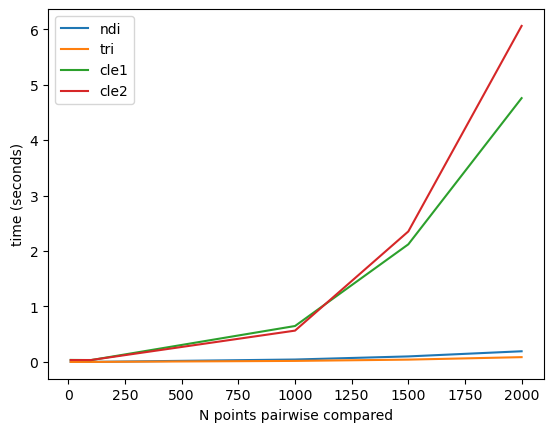

In [20]:
plt.plot(sizes, times_ndi, label = 'ndi')
plt.plot(sizes, times_tri, label = 'tri')
plt.plot(sizes, times_cle1, label = 'cle')
plt.plot(sizes, times_cle2, label = 'cle')

plt.xlabel('N points pairwise compared')
plt.ylabel('time (seconds)')
plt.legend(['ndi', 'tri', 'cle1', 'cle2'])
plt.show()